## Introduction


The Enron-Spam is a collection of spam/ham dataset by V. Metsis, I. Androutsopoulos and G. Paliouras and described in their publication "Spam Filtering with Naive Bayes - Which Naive Bayes?".
    
This dataset contains 17,171 spam and 16,545 non-spam ("ham") e-mail messages (33,716 in total).
The raw dataset and documentation can be accessed via the following link: http://www2.aueb.gr/users/ion/data/enron-spam/

The original dataset has every single mail in a seperate txt file and distributed over several directories.
The following repository (https://github.com/MWiechmann/enron_spam_data) converted the unprocessed data into a more structured format that offers a single download (https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip) of the data through a simple csv file, making further preprocessing of this dataset less cumbersome.

### import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Import and Read Data

In [2]:
enron_emails = pd.read_csv('../data/enron_spam_data.csv')

In [3]:
enron_emails.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


### 2. Dataset Stats

In [4]:
# verify total number of emails
enron_emails.shape

(33716, 5)

In [5]:
enron_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


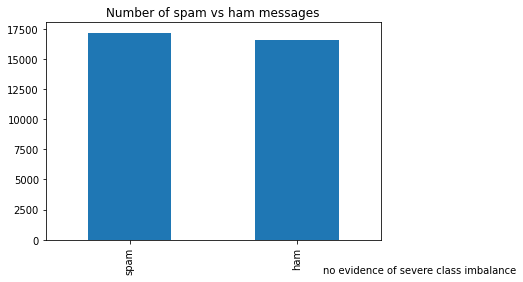

In [6]:
# verify total number of spam and hams
enron_emails['Spam/Ham'].value_counts().plot(kind = 'bar')
plt.figtext(0.99, 0.01, 'no evidence of severe class imbalance', horizontalalignment = 'center')
plt.title("Number of spam vs ham messages");